In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

# Load clustering data
X_scaled = pd.read_csv("model_data/cluster_X_scaled.csv")
metadata = pd.read_csv("model_data/cluster_metadata.csv")

# Also load full featured dataset for profiling later
df = pd.read_csv("data/processed/vgsales_featured.csv")
df_cluster = df[df["Global_Sales"] >= 0.1].copy().reset_index(drop=True)

print(f"Clustering dataset: {X_scaled.shape[0]:,} games × {X_scaled.shape[1]} features")
print(f"\nFeatures: {list(X_scaled.columns)}")
print(f"\nScaled feature stats:\n{X_scaled.describe().round(2)}")

Clustering dataset: 10,649 games × 8 features

Features: ['NA_Share', 'EU_Share', 'JP_Share', 'Genre_NA_Affinity', 'Genre_EU_Affinity', 'Genre_JP_Affinity', 'Platform_Age', 'Publisher_Genre_Spec']

Scaled feature stats:
       NA_Share  EU_Share  JP_Share  Genre_NA_Affinity  Genre_EU_Affinity  \
count  10649.00  10649.00  10649.00           10649.00           10649.00   
mean       0.00      0.00      0.00              -0.00               0.00   
std        1.00      1.00      1.00               1.00               1.00   
min       -1.73     -1.17     -0.52              -3.49              -3.38   
25%       -0.63     -0.99     -0.52              -0.49              -0.59   
50%        0.09     -0.06     -0.52              -0.07               0.17   
75%        0.83      0.70     -0.10               0.91               0.52   
max        1.68      3.80      2.45               3.57               8.07   

       Genre_JP_Affinity  Platform_Age  Publisher_Genre_Spec  
count           10649.0

  k=2: Inertia=64,595 | Silhouette=0.3497
  k=3: Inertia=55,729 | Silhouette=0.2060
  k=4: Inertia=48,313 | Silhouette=0.2355
  k=5: Inertia=43,427 | Silhouette=0.2109
  k=6: Inertia=39,261 | Silhouette=0.2137
  k=7: Inertia=36,204 | Silhouette=0.2153
  k=8: Inertia=33,451 | Silhouette=0.2255
  k=9: Inertia=31,034 | Silhouette=0.2215
  k=10: Inertia=29,480 | Silhouette=0.2316


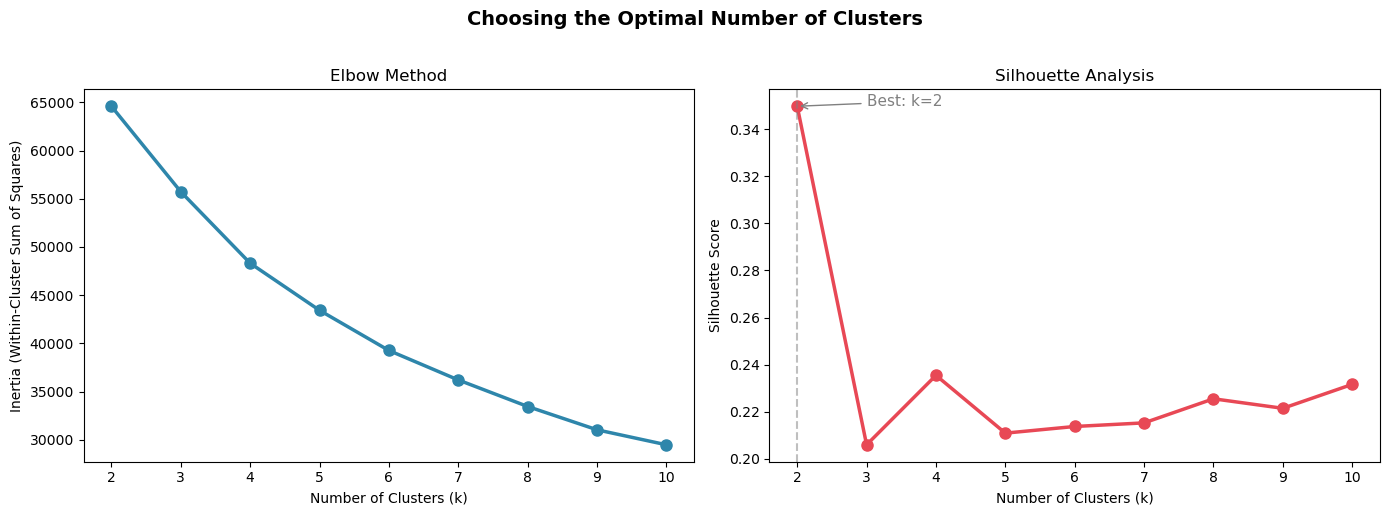


✅ Best silhouette score at k=2 (0.3497)


In [58]:
K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    print(f"  k={k}: Inertia={km.inertia_:,.0f} | Silhouette={silhouette_scores[-1]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(K_range, inertias, "o-", color="#2E86AB", linewidth=2.5, markersize=8)
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Inertia (Within-Cluster Sum of Squares)")
axes[0].set_title("Elbow Method")
axes[0].set_xticks(list(K_range))

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, "o-", color="#E84855", linewidth=2.5, markersize=8)
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Analysis")
axes[1].set_xticks(list(K_range))

# Highlight best silhouette
best_k = list(K_range)[np.argmax(silhouette_scores)]
axes[1].axvline(best_k, color="gray", linestyle="--", alpha=0.5)
axes[1].annotate(f"Best: k={best_k}", xy=(best_k, max(silhouette_scores)),
                 xytext=(best_k + 1, max(silhouette_scores)),
                 fontsize=11, color="gray", arrowprops=dict(arrowstyle="->", color="gray"))

fig.suptitle("Choosing the Optimal Number of Clusters", fontsize=14, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()

print(f"\n✅ Best silhouette score at k={best_k} ({max(silhouette_scores):.4f})")

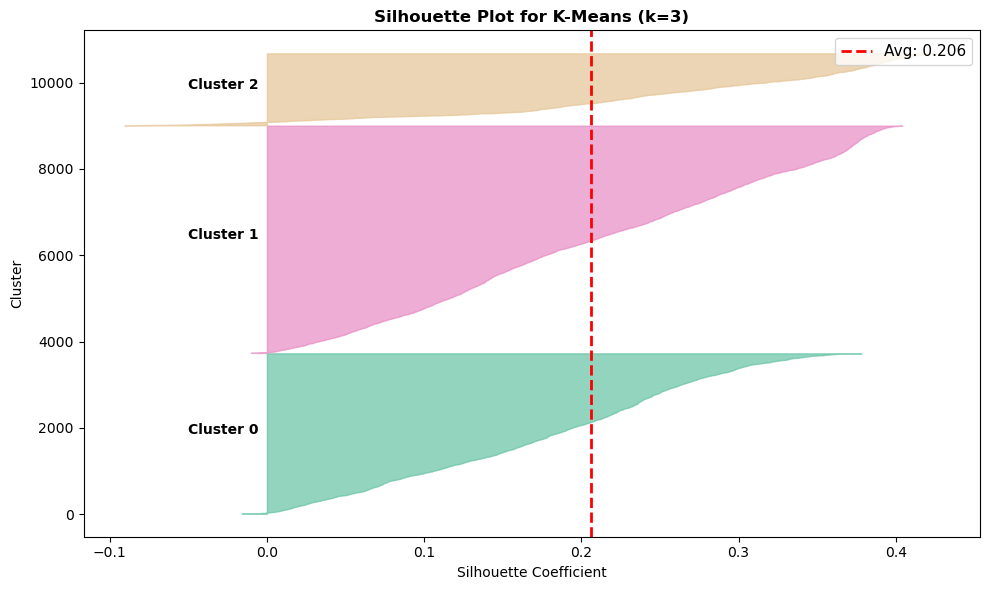

In [59]:
OPTIMAL_K = 3

km_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = km_final.fit_predict(X_scaled)
fig, ax = plt.subplots(figsize=(10, 6))
sample_silhouette = silhouette_samples(X_scaled, cluster_labels)
y_lower = 10

colors = plt.cm.Set2(np.linspace(0, 0.8, OPTIMAL_K))

for i in range(OPTIMAL_K):
    cluster_silhouette = sample_silhouette[cluster_labels == i]
    cluster_silhouette.sort()
    
    size = cluster_silhouette.shape[0]
    y_upper = y_lower + size
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size, f"Cluster {i}", fontsize=10, fontweight="bold")
    y_lower = y_upper + 10

avg_score = silhouette_score(X_scaled, cluster_labels)
ax.axvline(avg_score, color="red", linestyle="--", linewidth=2, label=f"Avg: {avg_score:.3f}")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.set_title(f"Silhouette Plot for K-Means (k={OPTIMAL_K})", fontweight="bold")
ax.legend(fontsize=11)
fig.tight_layout()
plt.show()

In [60]:
df_cluster["Cluster_KMeans"] = cluster_labels

print(f"K-Means Clustering (k={OPTIMAL_K}):")
print(f"{'='*50}")
for i in range(OPTIMAL_K):
    count = (cluster_labels == i).sum()
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {i}: {count:,} games ({pct:.1f}%)")


K-Means Clustering (k=3):
  Cluster 0: 3,717 games (34.9%)
  Cluster 1: 5,265 games (49.4%)
  Cluster 2: 1,667 games (15.7%)


In [61]:
# --- 5a. Regional Sales Profile ---
regional_cols = ["NA_Share", "EU_Share", "JP_Share"]
cluster_regional = df_cluster.groupby("Cluster_KMeans")[regional_cols].mean()

print("\nRegional Sales Profile (avg % share per cluster):")
print("=" * 55)
print(cluster_regional.round(1).to_string())

# --- 5b. Full Profile ---
profile = df_cluster.groupby("Cluster_KMeans").agg(
    n_games=("Name", "count"),
    avg_sales=("Global_Sales", "mean"),
    median_sales=("Global_Sales", "median"),
    hit_rate=("Is_Hit", "mean"),
    avg_NA_share=("NA_Share", "mean"),
    avg_EU_share=("EU_Share", "mean"),
    avg_JP_share=("JP_Share", "mean"),
    avg_platform_age=("Platform_Age", "mean"),
    top_genre=("Genre", lambda x: x.value_counts().index[0]),
    top_publisher_tier=("Publisher_Tier", lambda x: x.value_counts().index[0]),
    top_platform_gen=("Platform_Gen", lambda x: x.value_counts().index[0]),
).round(3)

print("\nFull Cluster Profile:")
print("=" * 80)
print(profile.to_string())


Regional Sales Profile (avg % share per cluster):
                NA_Share  EU_Share  JP_Share
Cluster_KMeans                              
0                   69.2      18.9       4.0
1                   52.2      33.5       4.1
2                    4.7       2.3      90.8

Full Cluster Profile:
                n_games  avg_sales  median_sales  hit_rate  avg_NA_share  avg_EU_share  avg_JP_share  avg_platform_age     top_genre top_publisher_tier top_platform_gen
Cluster_KMeans                                                                                                                                                          
0                  3717      0.802          0.32     0.366        69.181        18.858         4.018             6.580        Sports                AAA         Handheld
1                  5265      0.917          0.41     0.445        52.226        33.465         4.087             6.264        Action                AAA            Gen 7
2                  1667  

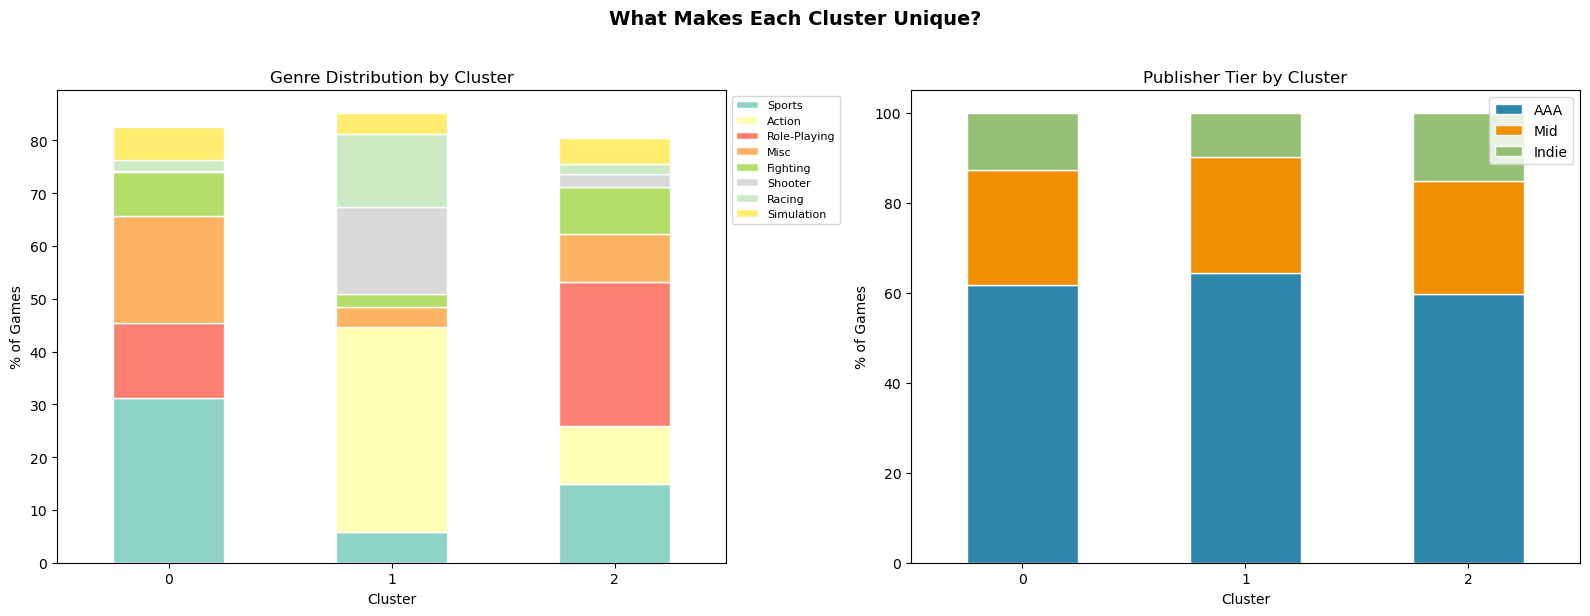

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Genre distribution per cluster
genre_cluster = pd.crosstab(df_cluster["Cluster_KMeans"], df_cluster["Genre"], normalize="index") * 100
genre_cluster = genre_cluster[genre_cluster.mean().sort_values(ascending=False).index]  # sort by popularity

genre_cluster.iloc[:, :8].plot(kind="bar", stacked=True, ax=axes[0],
                                colormap="Set3", edgecolor="white")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("% of Games")
axes[0].set_title("Genre Distribution by Cluster")
axes[0].legend(bbox_to_anchor=(1.0, 1.0), fontsize=8)
axes[0].tick_params(axis="x", rotation=0)

# Publisher tier distribution per cluster
tier_cluster = pd.crosstab(df_cluster["Cluster_KMeans"], df_cluster["Publisher_Tier"], normalize="index") * 100
tier_colors = {"AAA": "#2E86AB", "Mid": "#F18F01", "Indie": "#95BF74"}
tier_cluster = tier_cluster[[c for c in ["AAA", "Mid", "Indie"] if c in tier_cluster.columns]]

tier_cluster.plot(kind="bar", stacked=True, ax=axes[1],
                  color=[tier_colors.get(c, "gray") for c in tier_cluster.columns],
                  edgecolor="white")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("% of Games")
axes[1].set_title("Publisher Tier by Cluster")
axes[1].legend(fontsize=10)
axes[1].tick_params(axis="x", rotation=0)

fig.suptitle("What Makes Each Cluster Unique?", fontsize=14, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()


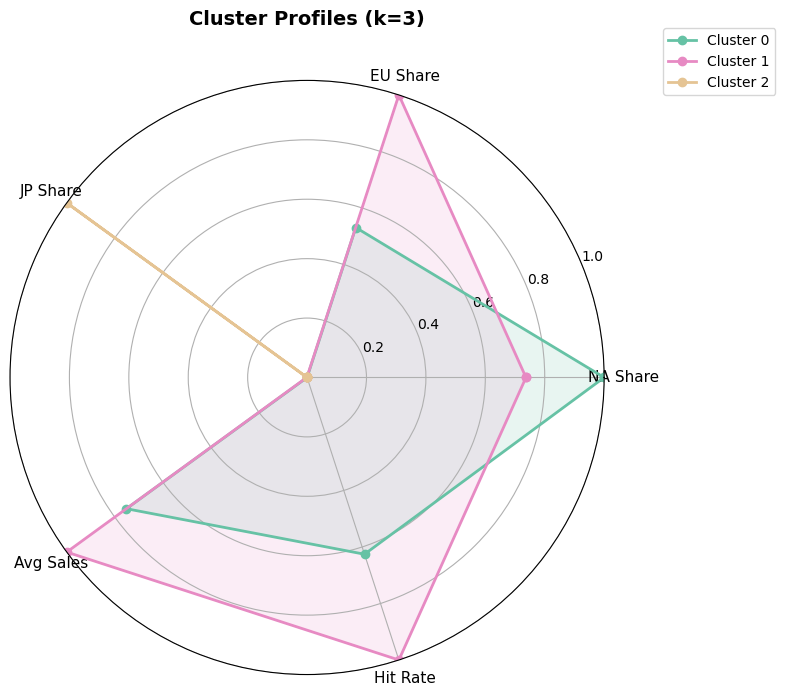

In [63]:
# Normalize profile features to 0-1 range for radar chart
radar_features = ["avg_NA_share", "avg_EU_share", "avg_JP_share", "avg_sales", "hit_rate"]
radar_data = profile[radar_features].copy()

# Min-max normalize each feature
for col in radar_features:
    min_val = radar_data[col].min()
    max_val = radar_data[col].max()
    if max_val > min_val:
        radar_data[col] = (radar_data[col] - min_val) / (max_val - min_val)
    else:
        radar_data[col] = 0.5

labels = ["NA Share", "EU Share", "JP Share", "Avg Sales", "Hit Rate"]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = plt.cm.Set2(np.linspace(0, 0.8, OPTIMAL_K))

for i in range(OPTIMAL_K):
    values = radar_data.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, "o-", linewidth=2, color=colors[i], label=f"Cluster {i}")
    ax.fill(angles, values, alpha=0.15, color=colors[i])

ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title(f"Cluster Profiles (k={OPTIMAL_K})", fontsize=14, fontweight="bold", y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)
fig.tight_layout()
plt.show()

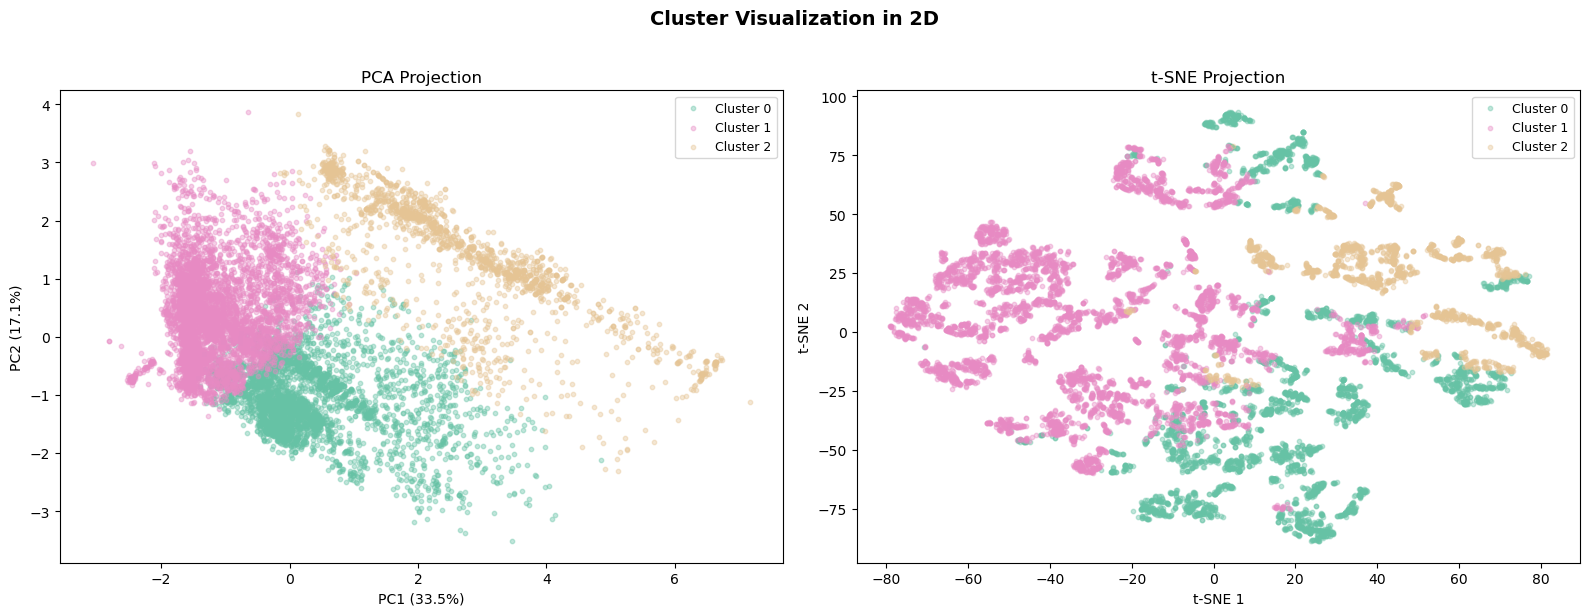


PCA explained variance: 50.5% with 2 components


In [64]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors_map = plt.cm.Set2(np.linspace(0, 0.8, OPTIMAL_K))

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

for i in range(OPTIMAL_K):
    mask = cluster_labels == i
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors_map[i]], 
                    alpha=0.4, s=10, label=f"Cluster {i}")

axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axes[0].set_title("PCA Projection")
axes[0].legend(fontsize=9)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

for i in range(OPTIMAL_K):
    mask = cluster_labels == i
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[colors_map[i]],
                    alpha=0.4, s=10, label=f"Cluster {i}")

axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].set_title("t-SNE Projection")
axes[1].legend(fontsize=9)

fig.suptitle("Cluster Visualization in 2D", fontsize=14, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()

print(f"\nPCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}% with 2 components")

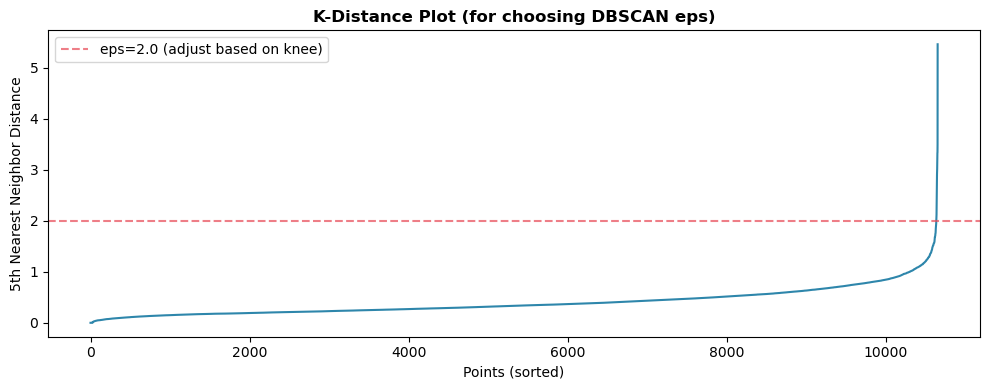

Look for the 'knee' in this plot — that's your eps value.
   Adjust the eps value below based on where the curve bends sharply.


In [65]:
# DBSCAN - find eps using nearest neighbor distances
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(distances, color="#2E86AB", linewidth=1.5)
ax.set_xlabel("Points (sorted)")
ax.set_ylabel("5th Nearest Neighbor Distance")
ax.set_title("K-Distance Plot (for choosing DBSCAN eps)", fontweight="bold")
ax.axhline(y=2.0, color="#E84855", linestyle="--", alpha=0.7, label="eps=2.0 (adjust based on knee)")
ax.legend()
fig.tight_layout()
plt.show()

print("Look for the 'knee' in this plot — that's your eps value.")
print("   Adjust the eps value below based on where the curve bends sharply.")

DBSCAN Results (eps=1.1, min_samples=10):
  Clusters found: 7
  Noise points: 200 (1.9%)
  Silhouette (excl. noise): 0.1668


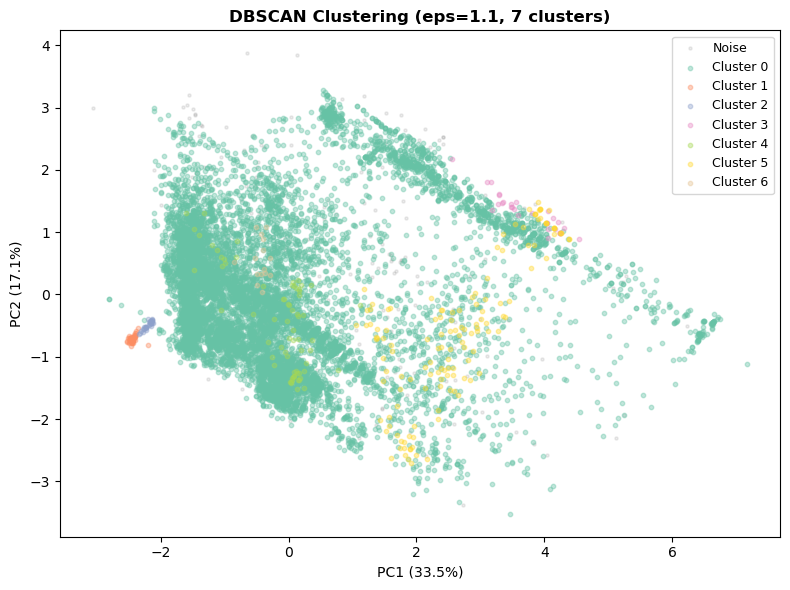

In [66]:
# Run DBSCAN — adjust eps based on the k-distance plot above
EPS = 1.1  
MIN_SAMPLES = 10

dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
db_labels = dbscan.fit_predict(X_scaled)

n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = (db_labels == -1).sum()

print(f"DBSCAN Results (eps={EPS}, min_samples={MIN_SAMPLES}):")
print(f"  Clusters found: {n_clusters_db}")
print(f"  Noise points: {n_noise:,} ({n_noise/len(db_labels)*100:.1f}%)")

if n_clusters_db >= 2:
    non_noise = db_labels != -1
    db_sil = silhouette_score(X_scaled[non_noise], db_labels[non_noise])
    print(f"  Silhouette (excl. noise): {db_sil:.4f}")
    
    df_cluster["Cluster_DBSCAN"] = db_labels
    
    # Visualize with PCA
    fig, ax = plt.subplots(figsize=(8, 6))
    unique_labels = sorted(set(db_labels))
    db_colors = plt.cm.Set2(np.linspace(0, 0.8, max(len(unique_labels), 1)))
    
    for i, label in enumerate(unique_labels):
        mask = db_labels == label
        if label == -1:
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c="gray", alpha=0.15, 
                       s=5, label="Noise")
        else:
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[db_colors[i]], 
                       alpha=0.4, s=10, label=f"Cluster {label}")
    
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_title(f"DBSCAN Clustering (eps={EPS}, {n_clusters_db} clusters)", fontweight="bold")
    ax.legend(fontsize=9)
    fig.tight_layout()
    plt.show()
else:
    print("  ⚠️ DBSCAN found fewer than 2 clusters. Try lowering eps or min_samples.")

In [67]:
if "Cluster_DBSCAN" in df_cluster.columns and n_clusters_db >= 2:
    print("K-Means vs DBSCAN Comparison:")
    print("=" * 50)
    
    km_sil = silhouette_score(X_scaled, cluster_labels)
    non_noise = db_labels != -1
    db_sil = silhouette_score(X_scaled[non_noise], db_labels[non_noise])
    
    comparison = pd.DataFrame({
        "K-Means": {
            "Clusters": OPTIMAL_K,
            "Silhouette Score": round(km_sil, 4),
            "Noise Points": 0,
            "Coverage": "100%"
        },
        "DBSCAN": {
            "Clusters": n_clusters_db,
            "Silhouette Score": round(db_sil, 4),
            "Noise Points": n_noise,
            "Coverage": f"{(1 - n_noise/len(db_labels))*100:.1f}%"
        }
    })
    print(comparison.to_string())

K-Means vs DBSCAN Comparison:
                 K-Means  DBSCAN
Clusters               3       7
Silhouette Score   0.206  0.1668
Noise Points           0     200
Coverage            100%   98.1%


In [68]:
# Print detailed info for each cluster to help you name them
print("\n" + "=" * 70)
print("  CLUSTER NAMING GUIDE")
print("=" * 70)

for i in range(OPTIMAL_K):
    cluster_data = df_cluster[df_cluster["Cluster_KMeans"] == i]
    
    print(f"\n--- Cluster {i} ({len(cluster_data):,} games) ---")
    
    # Regional profile
    na = cluster_data["NA_Share"].mean()
    eu = cluster_data["EU_Share"].mean()
    jp = cluster_data["JP_Share"].mean()
    print(f"  Region split: NA {na:.1f}% | EU {eu:.1f}% | JP {jp:.1f}%")
    
    # Top genres
    top_genres = cluster_data["Genre"].value_counts().head(3)
    print(f"  Top genres: {', '.join([f'{g} ({c})' for g, c in top_genres.items()])}")
    
    # Hit rate and sales
    print(f"  Hit rate: {cluster_data['Is_Hit'].mean()*100:.1f}%")
    print(f"  Avg sales: ${cluster_data['Global_Sales'].mean():.2f}M | "
          f"Median: ${cluster_data['Global_Sales'].median():.2f}M")
    
    # Publisher tier
    tier_dist = cluster_data["Publisher_Tier"].value_counts(normalize=True) * 100
    print(f"  Publisher mix: {', '.join([f'{t}: {p:.0f}%' for t, p in tier_dist.items()])}")
    
    # Example games (top sellers)
    examples = cluster_data.nlargest(5, "Global_Sales")[["Name", "Genre", "Global_Sales"]]
    print(f"  Top games:")
    for _, row in examples.iterrows():
        print(f"    • {row['Name']} ({row['Genre']}) — ${row['Global_Sales']:.2f}M")

print("\n" + "=" * 70)
print("💡 Based on the profiles above, give each cluster a descriptive name!")
print("   Examples: 'Japan-Centric RPGs', 'Western Blockbusters', 'Global Mainstream'")
print("=" * 70)


  CLUSTER NAMING GUIDE

--- Cluster 0 (3,717 games) ---
  Region split: NA 69.2% | EU 18.9% | JP 4.0%
  Top genres: Sports (1157), Misc (750), Role-Playing (531)
  Hit rate: 36.6%
  Avg sales: $0.80M | Median: $0.32M
  Publisher mix: AAA: 62%, Mid: 25%, Indie: 13%
  Top games:
    • Wii Sports (Sports) — $82.74M
    • Super Mario Bros. (Platform) — $40.24M
    • Wii Sports Resort (Sports) — $33.00M
    • Pokemon Red/Pokemon Blue (Role-Playing) — $31.37M
    • Tetris (Puzzle) — $30.26M

--- Cluster 1 (5,265 games) ---
  Region split: NA 52.2% | EU 33.5% | JP 4.1%
  Top genres: Action (2042), Shooter (866), Racing (727)
  Hit rate: 44.5%
  Avg sales: $0.92M | Median: $0.41M
  Publisher mix: AAA: 64%, Mid: 26%, Indie: 10%
  Top games:
    • Mario Kart Wii (Racing) — $35.82M
    • New Super Mario Bros. (Platform) — $30.01M
    • New Super Mario Bros. Wii (Platform) — $28.62M
    • Duck Hunt (Shooter) — $28.31M
    • Nintendogs (Simulation) — $24.76M

--- Cluster 2 (1,667 games) ---
  Regi

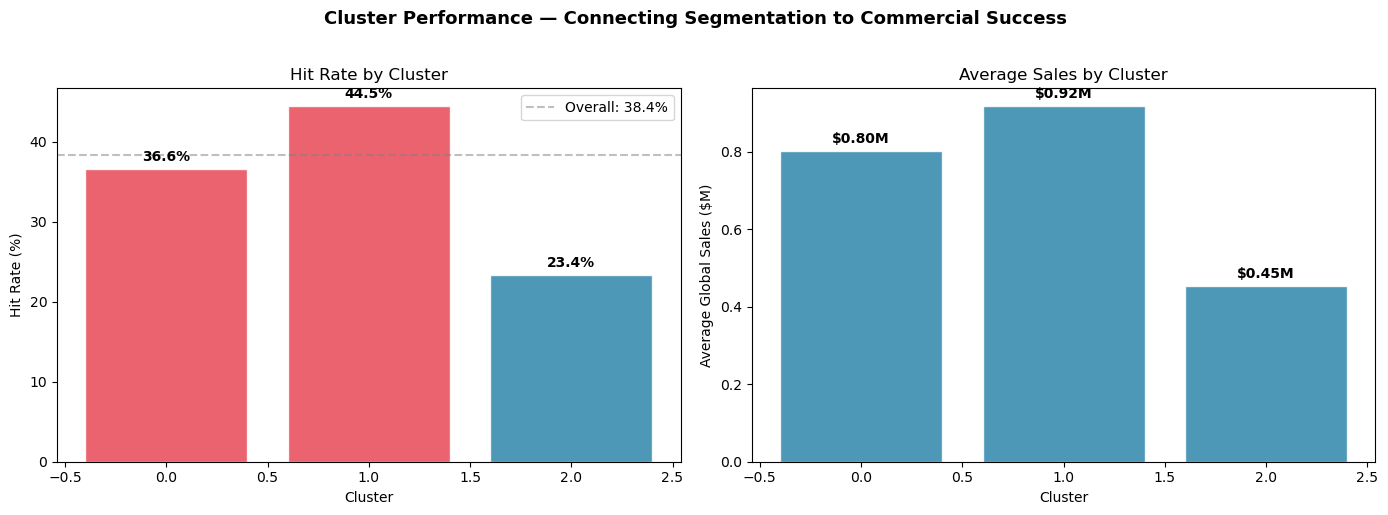

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hit rate by cluster
hit_rates = df_cluster.groupby("Cluster_KMeans")["Is_Hit"].mean() * 100
colors_hr = ["#E84855" if h > 30 else "#2E86AB" for h in hit_rates.values]
bars = axes[0].bar(hit_rates.index, hit_rates.values, color=colors_hr, edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Hit Rate (%)")
axes[0].set_title("Hit Rate by Cluster")
axes[0].axhline(df_cluster["Is_Hit"].mean() * 100, color="gray", linestyle="--", 
                alpha=0.5, label=f"Overall: {df_cluster['Is_Hit'].mean()*100:.1f}%")
axes[0].legend()
for bar, val in zip(bars, hit_rates.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%",
                 ha="center", fontsize=10, fontweight="bold")

# Avg sales by cluster
avg_sales = df_cluster.groupby("Cluster_KMeans")["Global_Sales"].mean()
bars2 = axes[1].bar(avg_sales.index, avg_sales.values, color="#2E86AB", edgecolor="white", alpha=0.85)
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Average Global Sales ($M)")
axes[1].set_title("Average Sales by Cluster")
for bar, val in zip(bars2, avg_sales.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.02, f"${val:.2f}M",
                 ha="center", fontsize=10, fontweight="bold")

fig.suptitle("Cluster Performance — Connecting Segmentation to Commercial Success",
             fontsize=13, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()